<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/3.model_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [20]:
import pandas as pd
from google.colab import drive
import pickle
import os

In [2]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [26]:
%%capture
git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'

files = [
    'sklearn_utils.py',
    'sklearn_transformers.py',
    'model.py',
    'path_manager.py'
]

def download_files(dict_):
    for file, url in dict_.items():
        !wget -O {file} {url} {file}
    
download_files(
    {
        file: git_download_path + file for file in files
    }
)

In [27]:
import importlib
import sklearn_transformers
import sklearn_utils 
import path_manager
import model

def reload_all(list_):
    for module in list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers,
        model
    ]
)

from model import Model
from path_manager import PathManager

# Setup paths

In [12]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1

pep8(_ih)

Mounted at /content/gdrive



In [16]:
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

pep8(_ih)

# Download models

In [17]:
models = manager.load_models()

In [18]:
models

{'elastic_net_final': ElasticNet(alpha=0.5, l1_ratio=0.2),
 'random_forest': RandomForestRegressor(n_estimators=500),
 'RF': RandomForestRegressor(max_depth=17, n_estimators=800),
 'Elastic': ElasticNet(),
 'SVM reg': SVR(),
 'Final': ElasticNet(alpha=0.5, l1_ratio=0.2),
 'RF_final': RandomForestRegressor(n_estimators=500),
 'ElasticSubmission': ElasticNet(alpha=0.5, l1_ratio=0.2)}

# Download data

In [21]:
df_test = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_processed.csv'
    ),
    index_col=[0]
)

# subsample from train.csv for testing
df_test_sample = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_sample_processed.csv'
    ),
    index_col=[0]
)

df_trainval = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'trainval_sample_processed.csv'
    ),
    index_col=[0]
)

X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

X_test_sample = df_test_sample.values[:, :-1]
Y_test_sample = df_test_sample.values[:, -1]

# Model mistake analysis

- From feature importance analysis, we see that the most important features are **opening year** and **city population**

# Feature importance

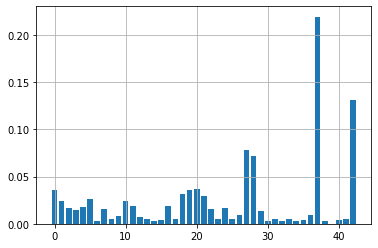

In [22]:
import numpy as np
import matplotlib.pyplot as plt

plt.bar(
    np.arange(len(models['RF'].feature_importances_)),
    models['RF'].feature_importances_
)
plt.grid()

pep8(_ih)

# Visualize trainval predictions

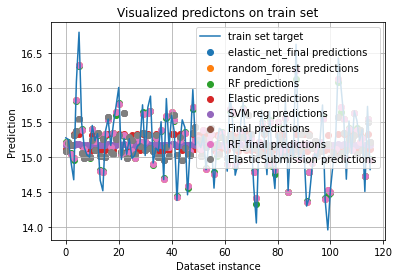

In [32]:
from sklearn_utils import visualize_regression_predictions

visualize_regression_predictions(
    # {'RF': models['RF']},
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    dataset_type_='train set'
)

# Selecting final model

- I select the best model, based on average cross validation score among fine-tuned models. At the same time, i track that this model does not overfit the trainset, and average cross-validation performance is comparable with train metrics

In [33]:
from sklearn_utils import print_model_cv_scores


_ = print_model_cv_scores(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

Model: SVM reg, mean: -0.23975755066794463, std: 0.10254520924351965
Model: Elastic, mean: -0.21569093211351922, std: 0.10074172443016455
Model: elastic_net_final, mean: -0.20073170318480518, std: 0.08848660198096124
Model: Final, mean: -0.20073170318480518, std: 0.08848660198096124
Model: ElasticSubmission, mean: -0.20073170318480518, std: 0.08848660198096124
Model: random_forest, mean: -0.19112075746859108, std: 0.06555809113542184
Model: RF_final, mean: -0.19096085480722, std: 0.06824290815213938
Model: RF, mean: -0.18903997353724675, std: 0.06635400940421186


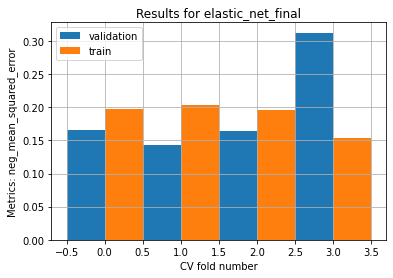

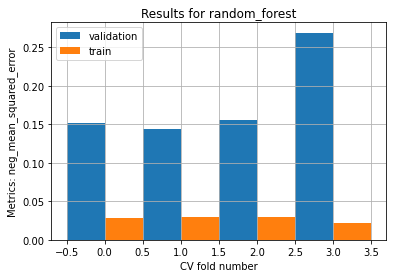

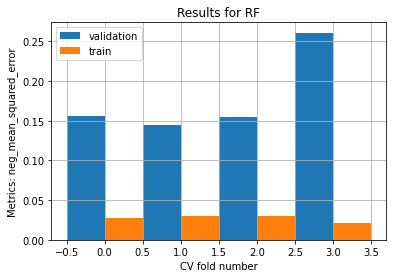

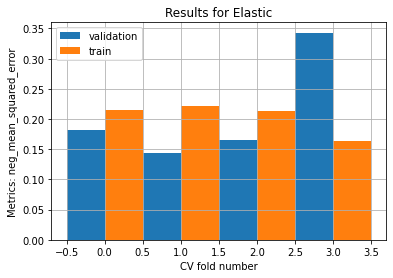

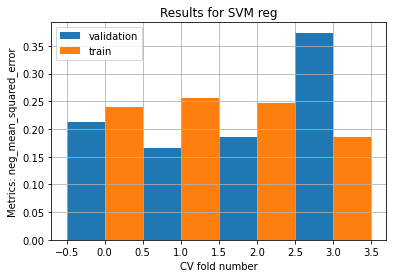

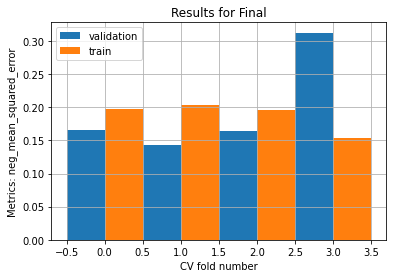

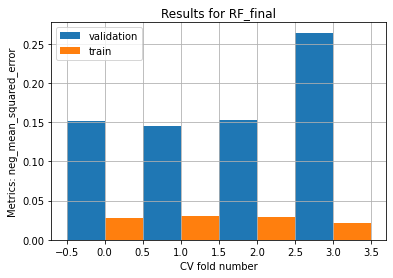

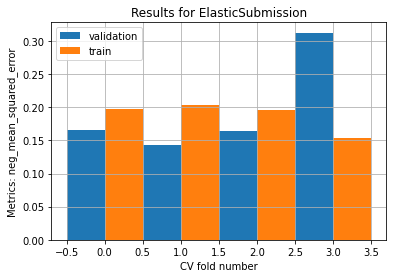

In [35]:
from sklearn_utils import plot_cv_results


_ = plot_cv_results(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

- My decision:
    - Random forest better captured the structure of the data (visualizations)
    - However, random forest overfits. Both version with n_estimators = 800 and 200 give approximately same average cross validation result. Hence, I use other model (e.g. Elastic regression)

In [36]:
models

{'elastic_net_final': ElasticNet(alpha=0.5, l1_ratio=0.2),
 'random_forest': RandomForestRegressor(n_estimators=500),
 'RF': RandomForestRegressor(max_depth=17, n_estimators=800),
 'Elastic': ElasticNet(),
 'SVM reg': SVR(),
 'Final': ElasticNet(alpha=0.5, l1_ratio=0.2),
 'RF_final': RandomForestRegressor(n_estimators=500),
 'ElasticSubmission': ElasticNet(alpha=0.5, l1_ratio=0.2)}

In [37]:
final_models = {
    'Final': models['elastic_net_final'],
    'RF_final': models['random_forest']
}

In [38]:
manager.save_models(
    final_models
)

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_1/Final already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_1/RF_final already exists
